# Notebook for generating and saving SBM CLUSTER graphs

In [6]:
import numpy as np
import torch
import pickle
import time

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.sparse


# Generate SBM CLUSTER graphs

In [7]:

def schuffle(W,c):
    # relabel the vertices at random
    idx=np.random.permutation( W.shape[0] )
    #idx2=np.argsort(idx) # for index ordering wrt classes
    W_new=W[idx,:]
    W_new=W_new[:,idx]
    c_new=c[idx]
    return W_new , c_new , idx 


def block_model(c,p,q):
    n=len(c)
    W=np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            if c[i]==c[j]:
                prob=p
            else:
                prob=q
            if np.random.binomial(1,prob)==1:
                W[i,j]=1
                W[j,i]=1     
    return W


def unbalanced_block_model(nb_of_clust, clust_size_min, clust_size_max, p, q):  
    c = []
    for r in range(nb_of_clust):
        if clust_size_max==clust_size_min:
            clust_size_r = clust_size_max
        else:
            clust_size_r = np.random.randint(clust_size_min,clust_size_max,size=1)[0]
        val_r = np.repeat(r,clust_size_r,axis=0)
        c.append(val_r)
    c = np.concatenate(c)  
    W = block_model(c,p,q)  
    return W,c


class generate_SBM_graph():

    def __init__(self, SBM_parameters): 

        # parameters
        nb_of_clust = SBM_parameters['nb_clusters']
        clust_size_min = SBM_parameters['size_min']
        clust_size_max = SBM_parameters['size_max']
        p = SBM_parameters['p']
        q = SBM_parameters['q']

        # block model
        W, c = unbalanced_block_model(nb_of_clust, clust_size_min, clust_size_max, p, q)
        
        # shuffle
        W, c, idx = schuffle(W,c)
        
        # signal on block model
        u = np.zeros(c.shape[0])
        for r in range(nb_of_clust):
            cluster = np.where(c==r)[0]
            s = cluster[np.random.randint(cluster.shape[0])]
            u[s] = r+1

        # target
        target = c
        
        # convert to pytorch
        W = torch.from_numpy(W)
        W = W.to(torch.int8)
        idx = torch.from_numpy(idx) 
        idx = idx.to(torch.int16)
        u = torch.from_numpy(u) 
        u = u.to(torch.int16)                      
        target = torch.from_numpy(target)
        target = target.to(torch.int16)
        
        # attributes
        self.nb_nodes = W.size(0)
        self.W = W
        self.rand_idx = idx
        self.node_feat = u
        self.node_label = target
        

    
    
    
# configuration   
SBM_parameters = {}
SBM_parameters['nb_clusters'] = 6 
SBM_parameters['size_min'] = 5 
SBM_parameters['size_max'] = 35 
SBM_parameters['p'] = 0.55 
SBM_parameters['q'] = 0.25 
print(SBM_parameters)
    

data = generate_SBM_graph(SBM_parameters)

print(data)
print(data.nb_nodes)
print(data.W)
print(data.rand_idx)
print(data.node_feat)
print(data.node_label)


{'nb_clusters': 6, 'size_min': 5, 'size_max': 35, 'p': 0.55, 'q': 0.25}
83
tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 1],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], dtype=torch.int8)
tensor([75, 32, 57, 38, 12, 14, 23,  3, 40, 56,  9,  0, 66, 68, 35, 67,  8, 79,
        64, 65, 33, 10, 39, 81, 21, 70, 78, 25, 27, 74, 37, 82, 71, 45, 19, 20,
        16, 54, 30, 55, 58, 51, 36, 52, 43, 47,  5, 13,  4, 24, 18,  1, 28, 44,
        61, 77, 60, 34, 26, 49, 46, 41, 63, 53, 17, 29, 72, 15, 11,  7, 22, 59,
        62,  6, 48, 31,  2, 73, 69, 42, 80, 50, 76], dtype=torch.int16)
tensor([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0], dtype=torch.int

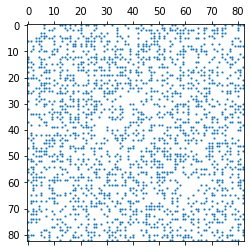

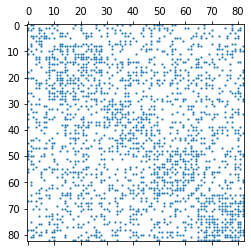

In [8]:
#Plot Adj matrix

W = data.W
plt.spy(W,precision=0.01, markersize=1)
plt.show()

idx = np.argsort(data.rand_idx) 
W = data.W
W2 = W[idx,:]
W2 = W2[:,idx]
plt.spy(W2,precision=0.01, markersize=1)
plt.show()


0
10
0
10
0
10
Time (sec): 2.803502082824707


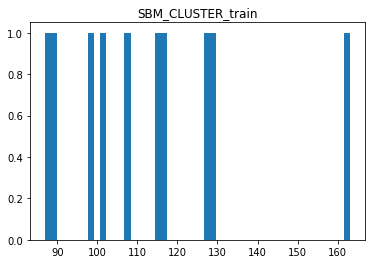

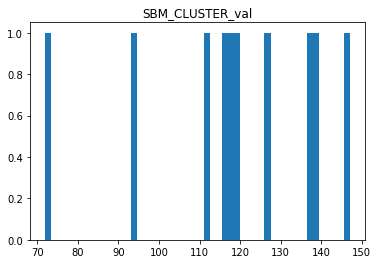

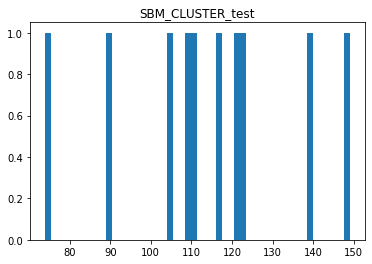

In [12]:
# Generate and save SBM graphs

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

def generate_semisuperclust_dataset(nb_graphs):
    dataset = []
    for i in range(nb_graphs):
        if not i%250:
            print(i)
        data = generate_SBM_graph(SBM_parameters)
        graph = DotDict()
        graph.nb_nodes = data.nb_nodes
        graph.W = data.W
        graph.rand_idx = data.rand_idx
        graph.node_feat = data.node_feat
        graph.node_label = data.node_label
        dataset.append(graph)
    return dataset

def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph.nb_nodes)
    plt.figure(1)
    plt.hist(graph_sizes, bins=50)
    plt.title(title)
    plt.show()
     
def SBMs_CLUSTER(nb_graphs, name):
    dataset = generate_semisuperclust_dataset(nb_graphs)
    print(len(dataset))
    with open(name+'.pkl',"wb") as f:
        pickle.dump(dataset,f)
    plot_histo_graphs(dataset,name)
    



start = time.time()

nb_graphs = 10 # train
#nb_graphs = 3333 # train
#nb_graphs = 500 # train
#nb_graphs = 20 # train
SBMs_CLUSTER(nb_graphs, 'SBM_CLUSTER_train')

import pickle

with open('SBM_CLUSTER_train.pkl', 'rb') as f:
    data = pickle.load(f)

data[5]

# with open('new_SBM_CLUSTER_train_before_smoothing.pkl', 'wb') as f:
#     pickle.dump(data, f)

# dataset = LoadData(SBM_CLUSTER) # 29s
# trainset, valset, testset = dataset.train, dataset.val, dataset.test

# with open('SBM_CLUSTER_train.pkl', 'rb') as f:
#     data = pickle.load(f)


import networkx as nx

#train = data

W_list = list(map(lambda d: d['W'].numpy(), data))
W_lists = list(map(lambda d: d['W'].numpy(), data))
rand_idx_list = list(map(lambda d: d['rand_idx'], data))
node_feat_list = list(map(lambda d: d['node_feat'], data))
node_label_list = list(map(lambda d: d['node_label'].numpy(), data))

class ProgressSmoothing:
    def __init__(self, g_nx):
        self.g_nx = g_nx

    def _get_weight_list(self, a, m, neighbor_list_dict):
        denominator = 0
        weight_list = [0 for _ in range(m)]
        for h in range(0, m):
            weighting = np.power(a, (m - h))
            # print(len(neighbor_list_dict[h]))
            num_nodes = len(neighbor_list_dict[h])
            weight_list[h] = weighting * num_nodes

            #             print(weighting, "@")
            #             print(num_nodes, "#")
            denominator += weighting * num_nodes
        #         print(type(denominator))
        #         print(type(weight_list))
        #        print(weight_list/denominator)
        return weight_list / denominator

    def nei_dict(self, hop_dict):
        neighbor_list_dict = {}  # neighbor_list_dict = {which_hop: [index1, index5, ....]}
        for u, h in hop_dict.items():  # hop_dict = {neighbor_id : which_hop}
            if not h in neighbor_list_dict.keys():
                n_list = [u]  # include self node
                neighbor_list_dict[h] = n_list
            else:
                neighbor_list_dict[h].append(u)
        return neighbor_list_dict

    def get_neigh_smooth_weight(self, v, a):
        #         hop_dict = nx.single_source_shortest_path_length(self.g_nx, v)
        hop_dict = nx.single_source_shortest_path_length(self.g_nx, v, 2)
        neighbor_list_dict = self.nei_dict(hop_dict)
        #         print(neighbor_list_dict)
        m = np.max(list(neighbor_list_dict.keys()))
        weight_list = self._get_weight_list(a, m, neighbor_list_dict)
        # print(weight_list)
        nidx_weight_list = []
        for h in range(0, m):
            for u in neighbor_list_dict[h]:
                nidx_weight_list.append((int(u), weight_list[h]))
        return nidx_weight_list

    def smooth_all(self, a, labels):
        total_nidx_weight_list = []
        for v in list(g_nx.nodes):
            # print(v)
            nidx_weight_list = self.get_neigh_smooth_weight(v, a)
            # print(nidx_weight_list)
            total_nidx_weight_list.extend(nidx_weight_list)
        smoothed_labels = labels.copy()
        smoothed_labels = smoothed_labels.astype(float)
        for u, w in total_nidx_weight_list:
            smoothed_labels[u] *= float(w)
        return smoothed_labels

train_label = []
for W, labels in zip(W_lists, node_label_list):
   # train_W =[]
#    W = W.numpy()
#    labels = node_label_list.numpy()
    g_nx = nx.from_numpy_matrix(W)
    ps = ProgressSmoothing(g_nx=g_nx)
    # train_W.append(W)
    train_label.append(ps.smooth_all(2, labels))

node_label = train_label

# new_data = [{'W':W, 'rand_idx': rand_idx, 'node_feat': node_feat, 'node_label': node_label}
#         for W, rand_idx, node_feat, node_label in zip(W_list, rand_idx_list, node_feat_list, node_label)]

for idx, smoothed_label in enumerate(node_label):
    data[idx]['node_label'] = torch.tensor(smoothed_label)

# ps = ProgressSmoothing(g_nx=g_nx)
# smoothed_labels = ps.smooth_all(2, labels)

# with open('new_SBM_CLUSTER_train_0402_03_dataset.pkl', 'wb') as f:
#     pickle.dump(data, f)
#
with open('smoothed_SBM_CLUSTER_0406', 'wb') as f:
     pickle.dump(data, f)

    
nb_graphs = 10 # val
#nb_graphs = 333 # val
#nb_graphs = 100 # val
#nb_graphs = 5 # val
SBMs_CLUSTER(nb_graphs, 'SBM_CLUSTER_val')

    
nb_graphs = 10 # test
#nb_graphs = 333 # test
#nb_graphs = 100 # test
#nb_graphs = 5 # test
SBMs_CLUSTER(nb_graphs, 'SBM_CLUSTER_test')

print('Time (sec):',time.time() - start) # 190s


# Convert to DGL format and save with pickle

In [13]:
import os
os.chdir('../../') # go to root folder of the project
print(os.getcwd())


C:\Users\user\Desktop\project\benchmarking_gnns


In [14]:

import pickle

%load_ext autoreload
%autoreload 2

from data.SBMs import SBMsDatasetDGL 

from data.data import LoadData
from torch.utils.data import DataLoader
from data.SBMs import SBMsDataset


In [15]:
DATASET_NAME = 'SBM_CLUSTER'
dataset = SBMsDatasetDGL(DATASET_NAME)  #3983s


[I] Loading data ...
preparing 10 graphs for the TRAIN set...
preparing 10 graphs for the TEST set...
preparing 10 graphs for the VAL set...
[I] Finished loading.
[I] Data load time: 14.3347s


In [16]:
print(len(dataset.train))
print(len(dataset.val))
print(len(dataset.test))

print(dataset.train[0])
print(dataset.val[0])
print(dataset.test[0])


10
10
10
(DGLGraph(num_nodes=90, num_edges=2588,
         ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor([2, 1, 3, 2, 2, 5, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 1, 3, 3, 1, 0, 1, 3, 0,
        3, 4, 2, 2, 3, 2, 2, 0, 1, 3, 4, 4, 0, 0, 1, 0, 3, 2, 2, 2, 2, 2, 3, 3,
        2, 3, 2, 2, 2, 4, 4, 5, 0, 1, 3, 0, 5, 4, 5, 5, 0, 1, 3, 2, 3, 3, 1, 3,
        3, 2, 2, 4, 2, 3, 2, 5, 3, 4, 3, 0, 2, 3, 3, 2, 2, 2],
       dtype=torch.int16))
(DGLGraph(num_nodes=93, num_edges=2606,
         ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor([5, 4, 0, 0, 4, 2, 0, 5, 1, 0, 4, 4, 2, 0, 2, 3, 2, 0, 0, 4, 2, 3, 2, 2,
        4, 2, 4, 4, 2, 5, 0, 0, 2, 4, 5, 0, 4, 0, 2, 3, 2, 4, 4, 5, 0, 4, 1, 0,
        0, 0, 5, 4, 4, 4, 4, 2, 1, 5, 0, 4, 2, 2, 4, 3, 5, 5, 4, 5, 4, 2, 5, 2,
        5, 2, 1, 5, 0, 5, 0, 1, 4, 5, 3, 0, 5, 0, 0, 

In [17]:
start = time.time()

with open('data/SBMs/SBM_CLUSTER.pkl','wb') as f:
        pickle.dump([dataset.train,dataset.val,dataset.test],f)
        
print('Time (sec):',time.time() - start)


Time (sec): 0.019947290420532227


# Test load function

In [18]:
DATASET_NAME = 'SBM_CLUSTER'
dataset = LoadData(DATASET_NAME) # 29s
trainset, valset, testset = dataset.train, dataset.val, dataset.test


[I] Loading dataset SBM_CLUSTER...
train, test, val sizes : 10 10 10
[I] Finished loading.
[I] Data load time: 0.0349s


In [19]:
start = time.time()

batch_size = 10
collate = SBMsDataset.collate
print(SBMsDataset)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)

print('Time (sec):',time.time() - start) #0.002s


<class 'data.SBMs.SBMsDataset'>
Time (sec): 0.0
